In [ ]:
!git clone https://github.com/deepraj1729/Track.git

Cloning into 'Track'...
remote: Enumerating objects: 15618, done.
remote: Counting objects: 100% (15618/15618), done.
remote: Compressing objects: 100% (15617/15617), done.
remote: Total 15618 (delta 6), reused 15608 (delta 1), pack-reused 0
Receiving objects: 100% (15618/15618), 3.45 MiB | 1.35 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
!ls Track

ls: cannot access 'Track': No such file or directory


In [ ]:
%cd Track

/content/Track


In [ ]:
!sudo apt-get install git-lfs
!git lfs pull

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 0s (20.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-pr

In [ ]:
!ls -F
print("Files loaded.")

driving_log.csv  IMG/  README.md  screens/
Files loaded.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [ ]:
datadir = "Track"
columns = ['center','left','right','steering','throttle','reverse','speed']

data = pd.read_csv('driving_log.csv',names = columns)
pd.set_option('display.expand_frame_repr', False)
print(data.head())

                                              center                                               left                                              right  steering  throttle  reverse     speed
0  F:\Udacity-Self-driving-car\training_images\IM...   F:\Udacity-Self-driving-car\training_images\I...   F:\Udacity-Self-driving-car\training_images\I...       0.0  0.000000      0.0  0.000082
1  F:\Udacity-Self-driving-car\training_images\IM...   F:\Udacity-Self-driving-car\training_images\I...   F:\Udacity-Self-driving-car\training_images\I...       0.0  0.000000      0.0  0.000079
2  F:\Udacity-Self-driving-car\training_images\IM...   F:\Udacity-Self-driving-car\training_images\I...   F:\Udacity-Self-driving-car\training_images\I...       0.0  0.000000      0.0  0.000084
3  F:\Udacity-Self-driving-car\training_images\IM...   F:\Udacity-Self-driving-car\training_images\I...   F:\Udacity-Self-driving-car\training_images\I...       0.0  0.027923      0.0  0.033287
4  F:\Udacity-Self-driving-car

In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail


data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_07_07_14_54_07_924.jpg,left_2020_07_07_14_54_07_924.jpg,right_2020_07_07_14_54_07_924.jpg,0.0,0.000000,0.0,0.000082
1,center_2020_07_07_14_54_08_027.jpg,left_2020_07_07_14_54_08_027.jpg,right_2020_07_07_14_54_08_027.jpg,0.0,0.000000,0.0,0.000079
2,center_2020_07_07_14_54_08_133.jpg,left_2020_07_07_14_54_08_133.jpg,right_2020_07_07_14_54_08_133.jpg,0.0,0.000000,0.0,0.000084
3,center_2020_07_07_14_54_08_237.jpg,left_2020_07_07_14_54_08_237.jpg,right_2020_07_07_14_54_08_237.jpg,0.0,0.027923,0.0,0.033287
4,center_2020_07_07_14_54_08_347.jpg,left_2020_07_07_14_54_08_347.jpg,right_2020_07_07_14_54_08_347.jpg,0.0,0.404990,0.0,0.316167


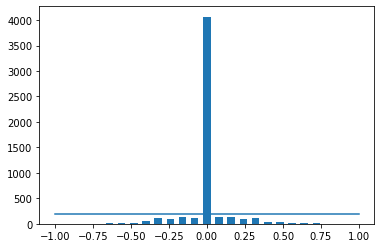

In [ ]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 5205
removed: 3866
remaining: 1339


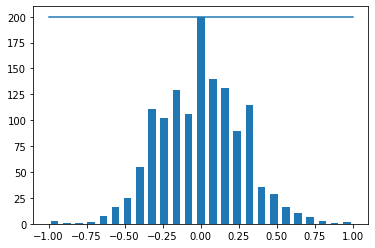

In [ ]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering('IMG', data)

center      center_2020_07_07_14_54_08_764.jpg
left          left_2020_07_07_14_54_08_764.jpg
right        right_2020_07_07_14_54_08_764.jpg
steering                                     0
throttle                                     1
reverse                                      0
speed                                  4.67726
Name: 8, dtype: object


In [ ]:
random.seed(0)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3213
Valid Samples: 804


Text(0.5, 1.0, 'Validation set')

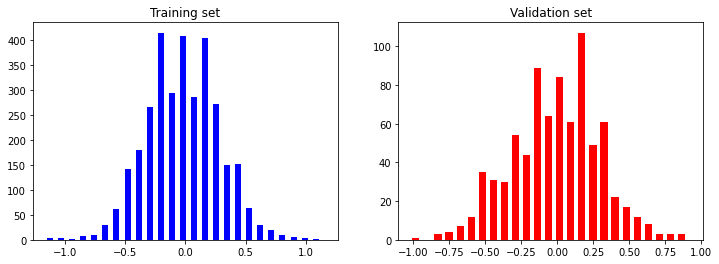

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def zoom(img):
  zoom = iaa.Affine(scale=(1, 1.3))
  img = zoom.augment_image(img)
  return img

Text(0.5, 1.0, 'Zoomed Image')

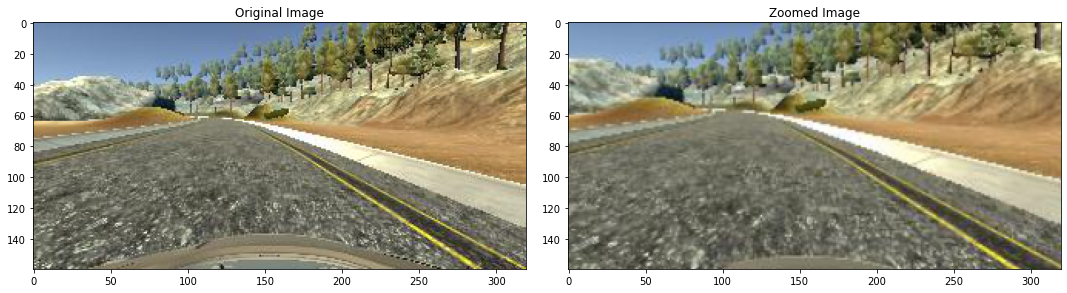

In [ ]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)


fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [ ]:
#Image panning (horizontal and vertical translation of image)
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned_Image')

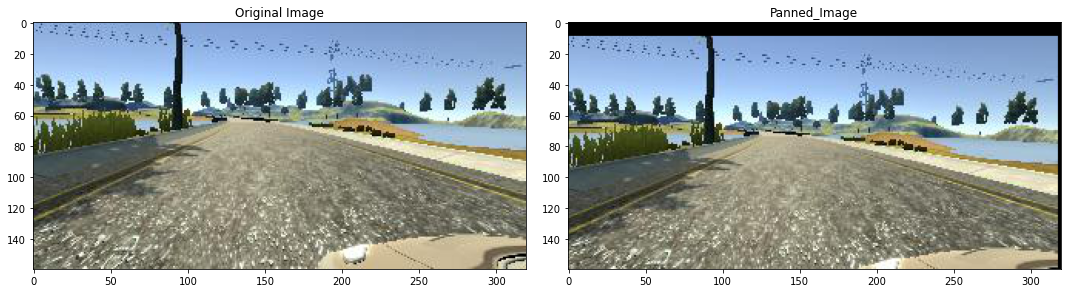

In [ ]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned_Image')

In [ ]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

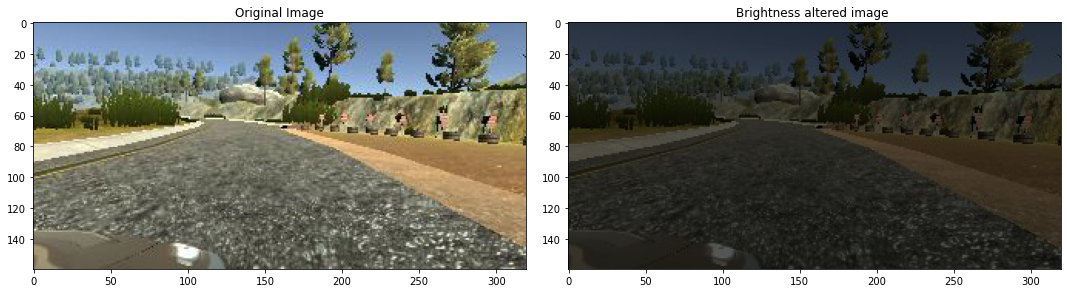

In [ ]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [ ]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.15')

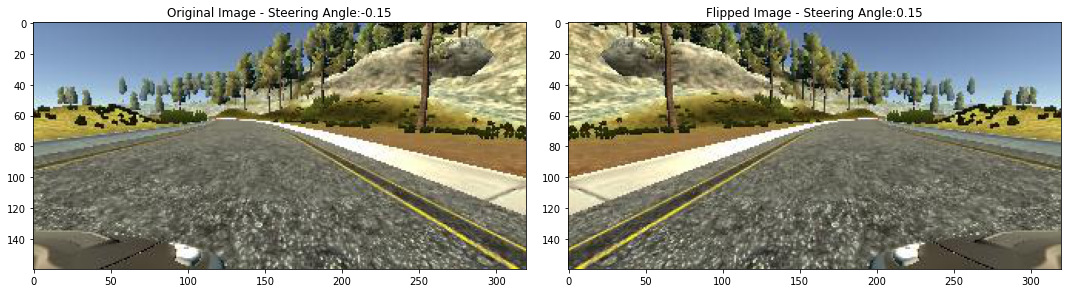

In [ ]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [ ]:
#Random Augmentation of the above augmentation methods
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

In [ ]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

Output hidden; open in https://colab.research.google.com to view.

Text(0.5, 1.0, 'Preprocessed Image')

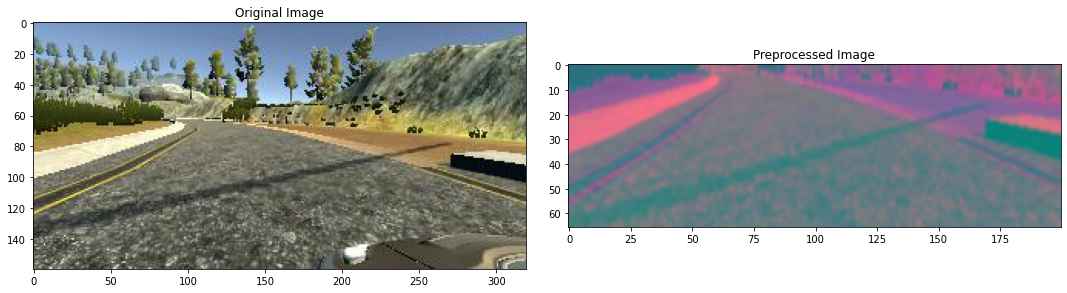

In [ ]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [ ]:
#Custom Image Data generator for our Augmentation techniques 
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        img, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        img = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      img = img_preprocess(img)
      batch_img.append(img)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

Text(0.5, 1.0, 'Validation Image')

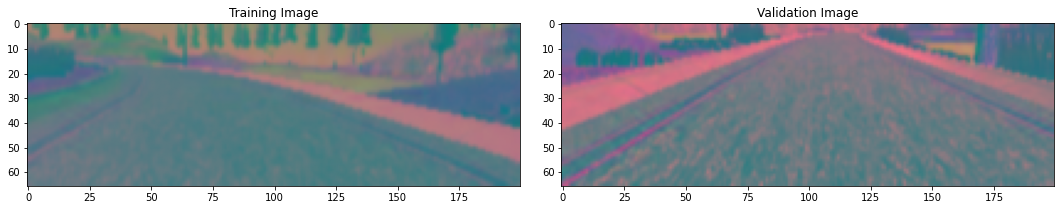

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24,(5,5),strides=(2, 2),input_shape=(66, 200, 3),activation='elu'))
  model.add(Convolution2D(36,(5,5),strides=(2, 2), activation='elu'))
  model.add(Convolution2D(48,(5,5),strides=(2, 2), activation='elu'))
  model.add(Convolution2D(64,(3,3),activation='elu'))
  model.add(Convolution2D(64,(3,3),activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

In [ ]:
# history = model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid),batch_size=100,verbose=1,shuffle=1)

history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=20,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/20
300/300 [==============================] - 219s 731ms/step - loss: 0.1815 - val_loss: 0.0698
Epoch 2/20
300/300 [==============================] - 221s 736ms/step - loss: 0.0851 - val_loss: 0.0656
Epoch 3/20
300/300 [==============================] - 220s 733ms/step - loss: 0.0803 - val_loss: 0.0617
Epoch 4/20
300/300 [==============================] - 219s 729ms/step - loss: 0.0783 - val_loss: 0.0555
Epoch 5/20
300/300 [==============================] - 218s 728ms/step - loss: 0.0763 - val_loss: 0.0570
Epoch 6/20
300/300 [==============================] - 219s 731ms/step - loss: 0.0728 - val_loss: 0.0533
Epoch 7/20
300/300 [==============================] - 220s 733ms/step - loss: 0.0718 - val_loss: 0.0536
Epoch 8/20
300/300 [==============================] - 218s 728ms/step - loss: 0.0730 - val_loss: 0.0521
Epoch 9/20
300/300 [==============================] - 219s 731ms/step - loss: 0.0722 - val_loss: 0.0519
Epoch 10/20
300/300 [==============================] - 220s 734m

Text(0.5, 0, 'Epoch')

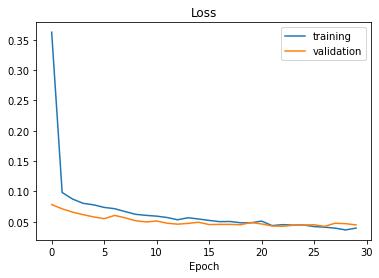

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>